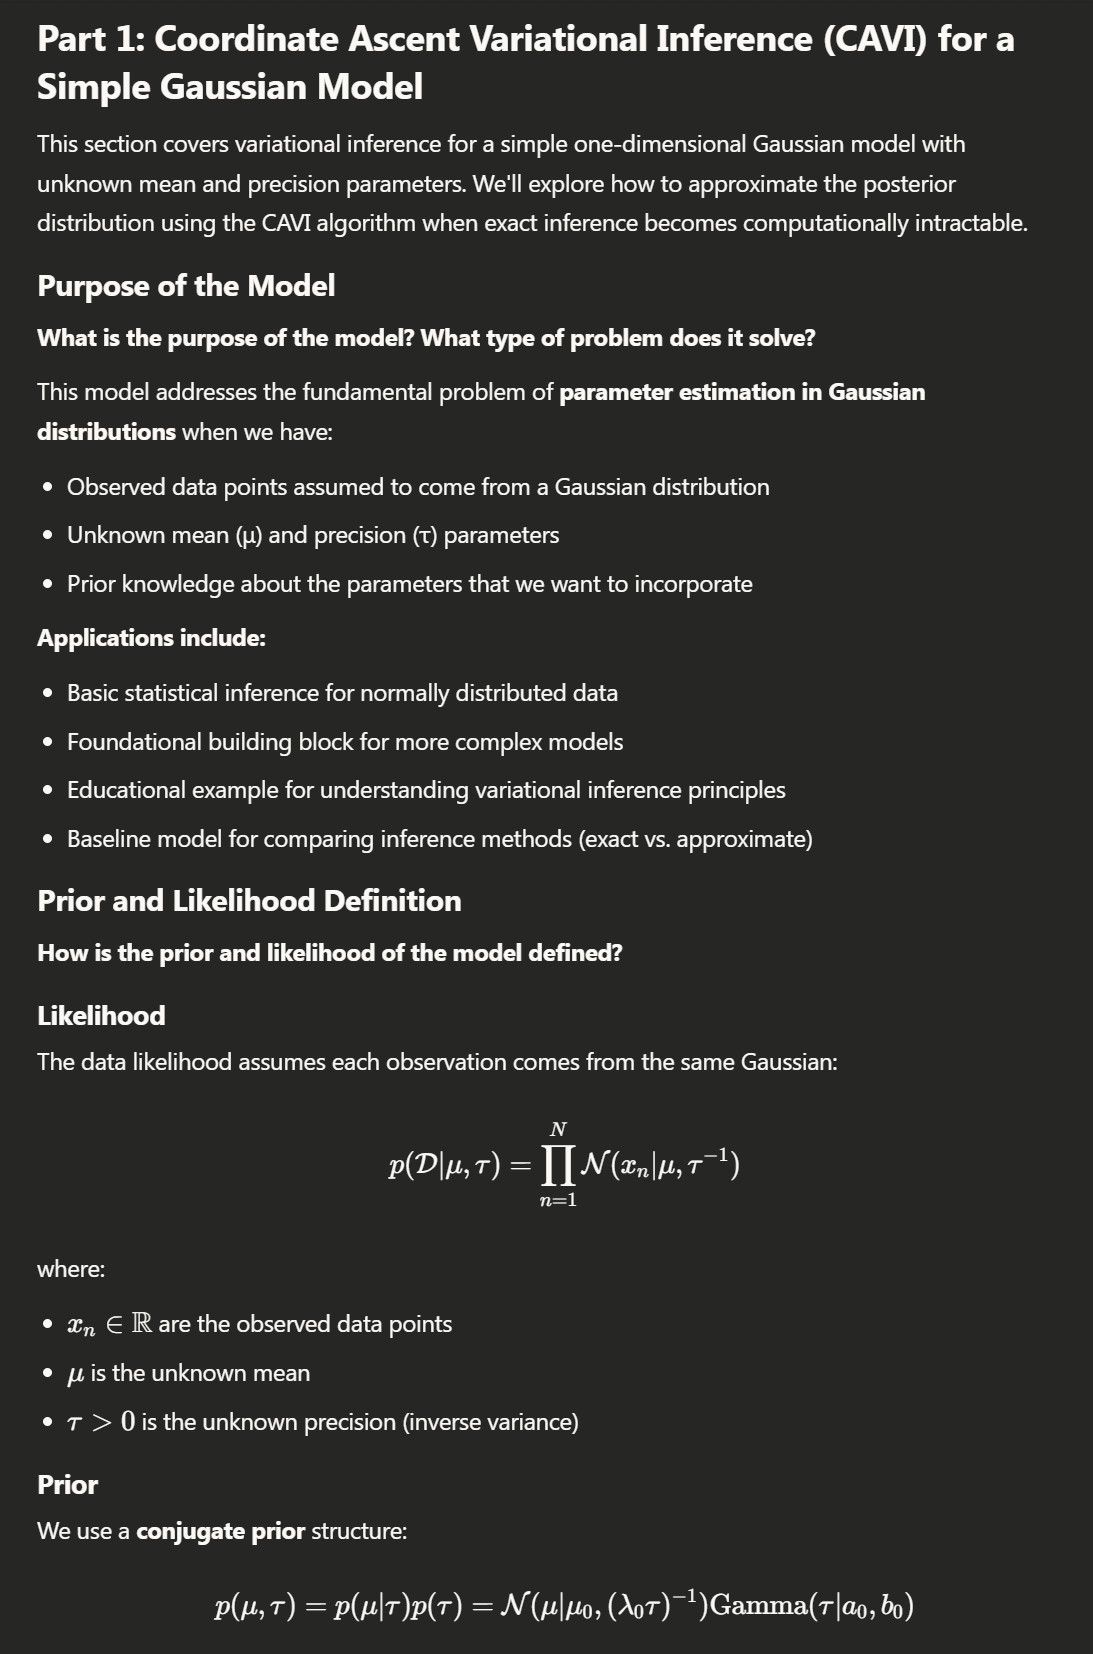
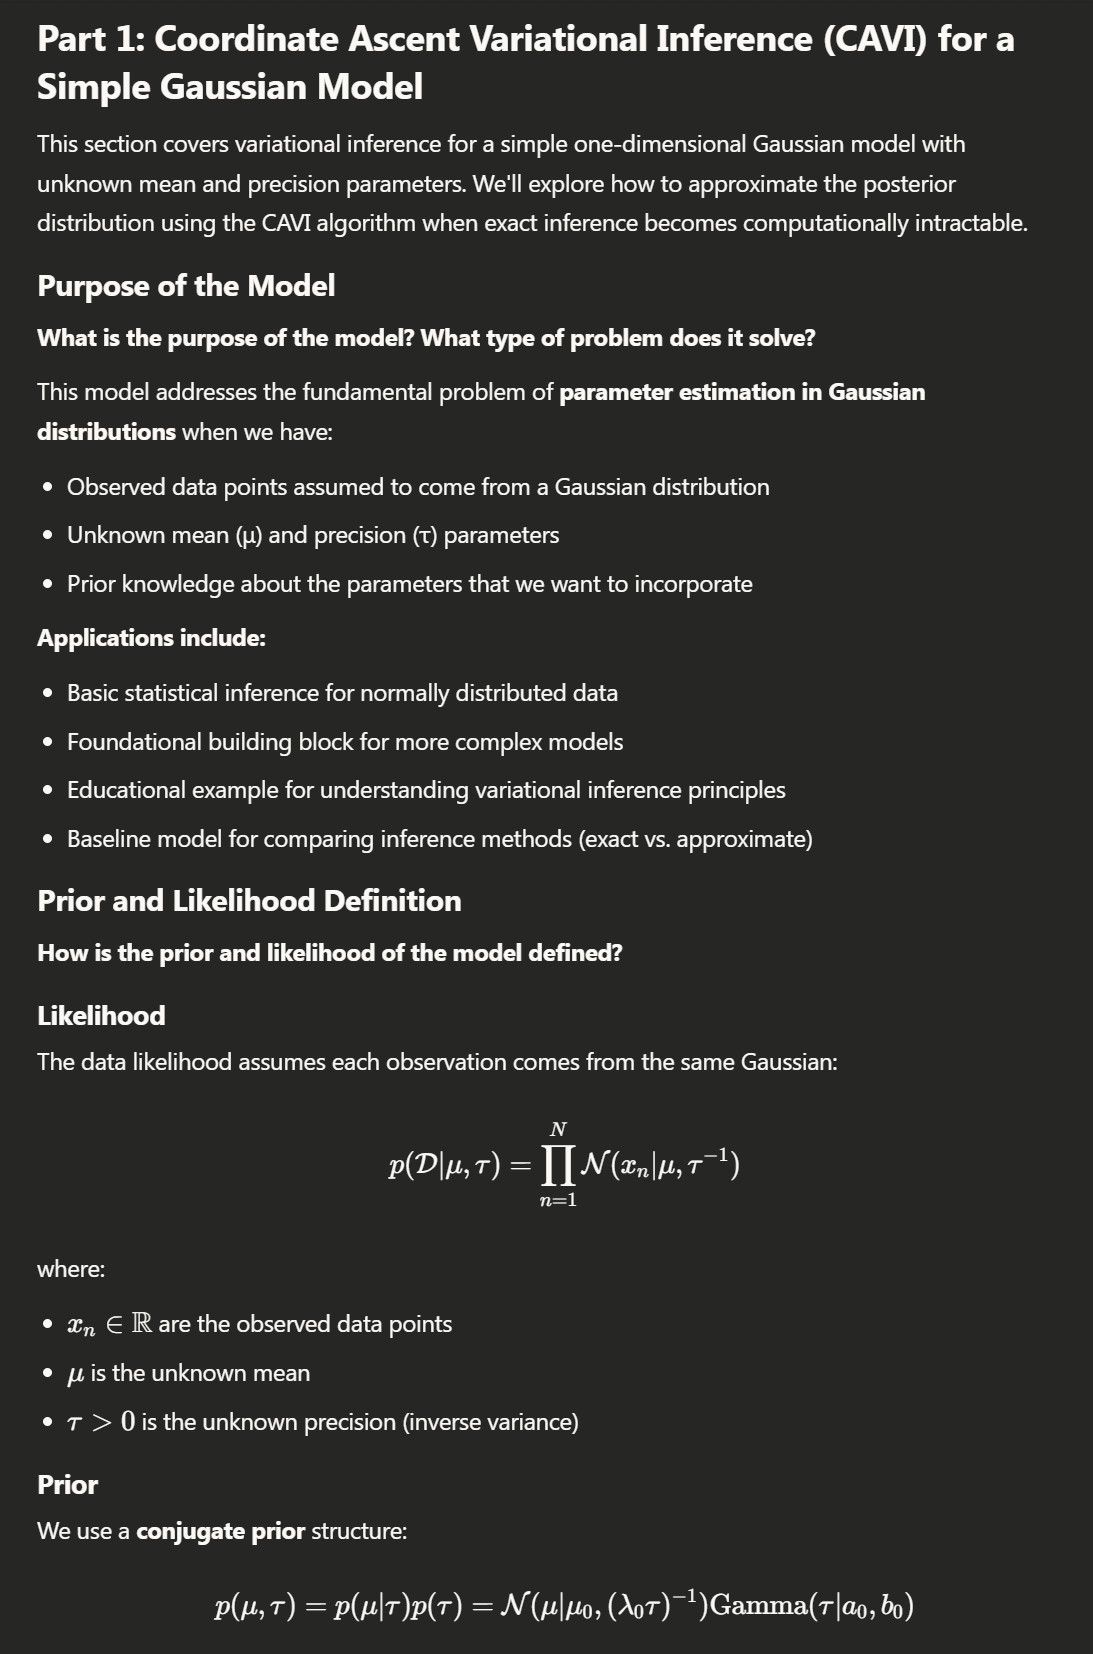
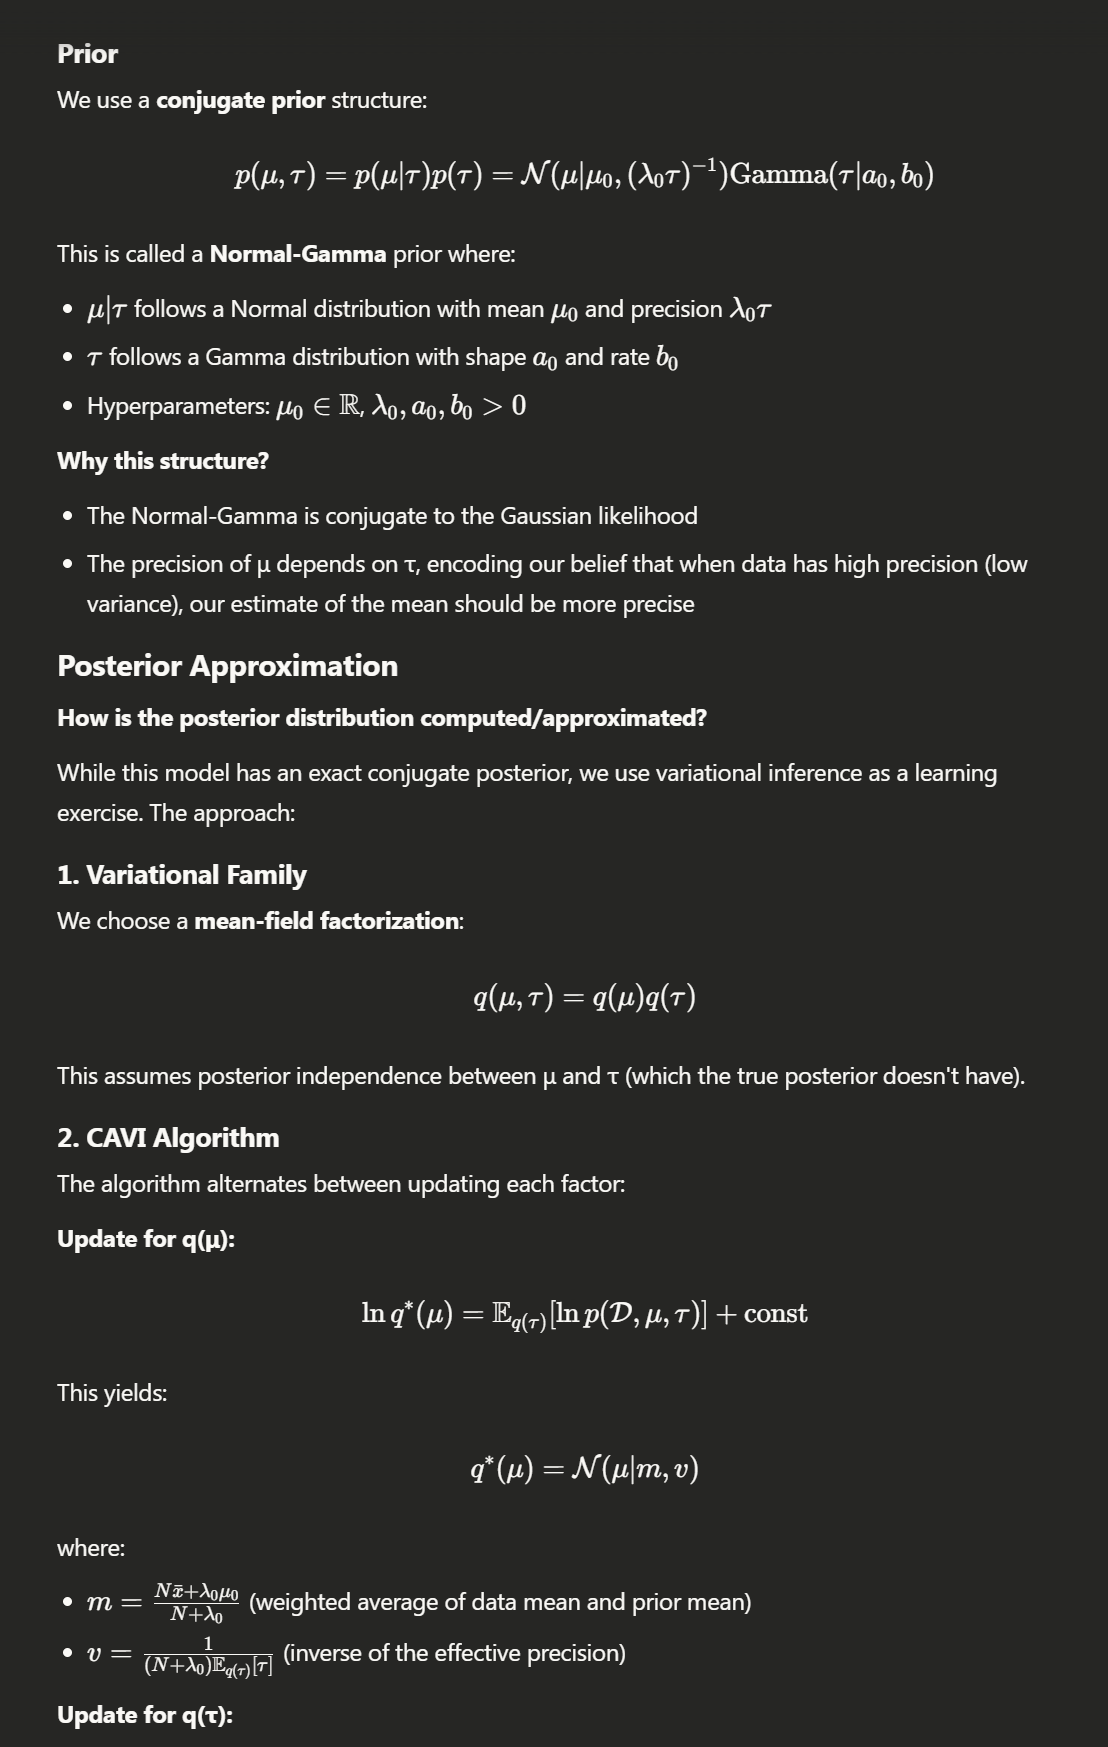
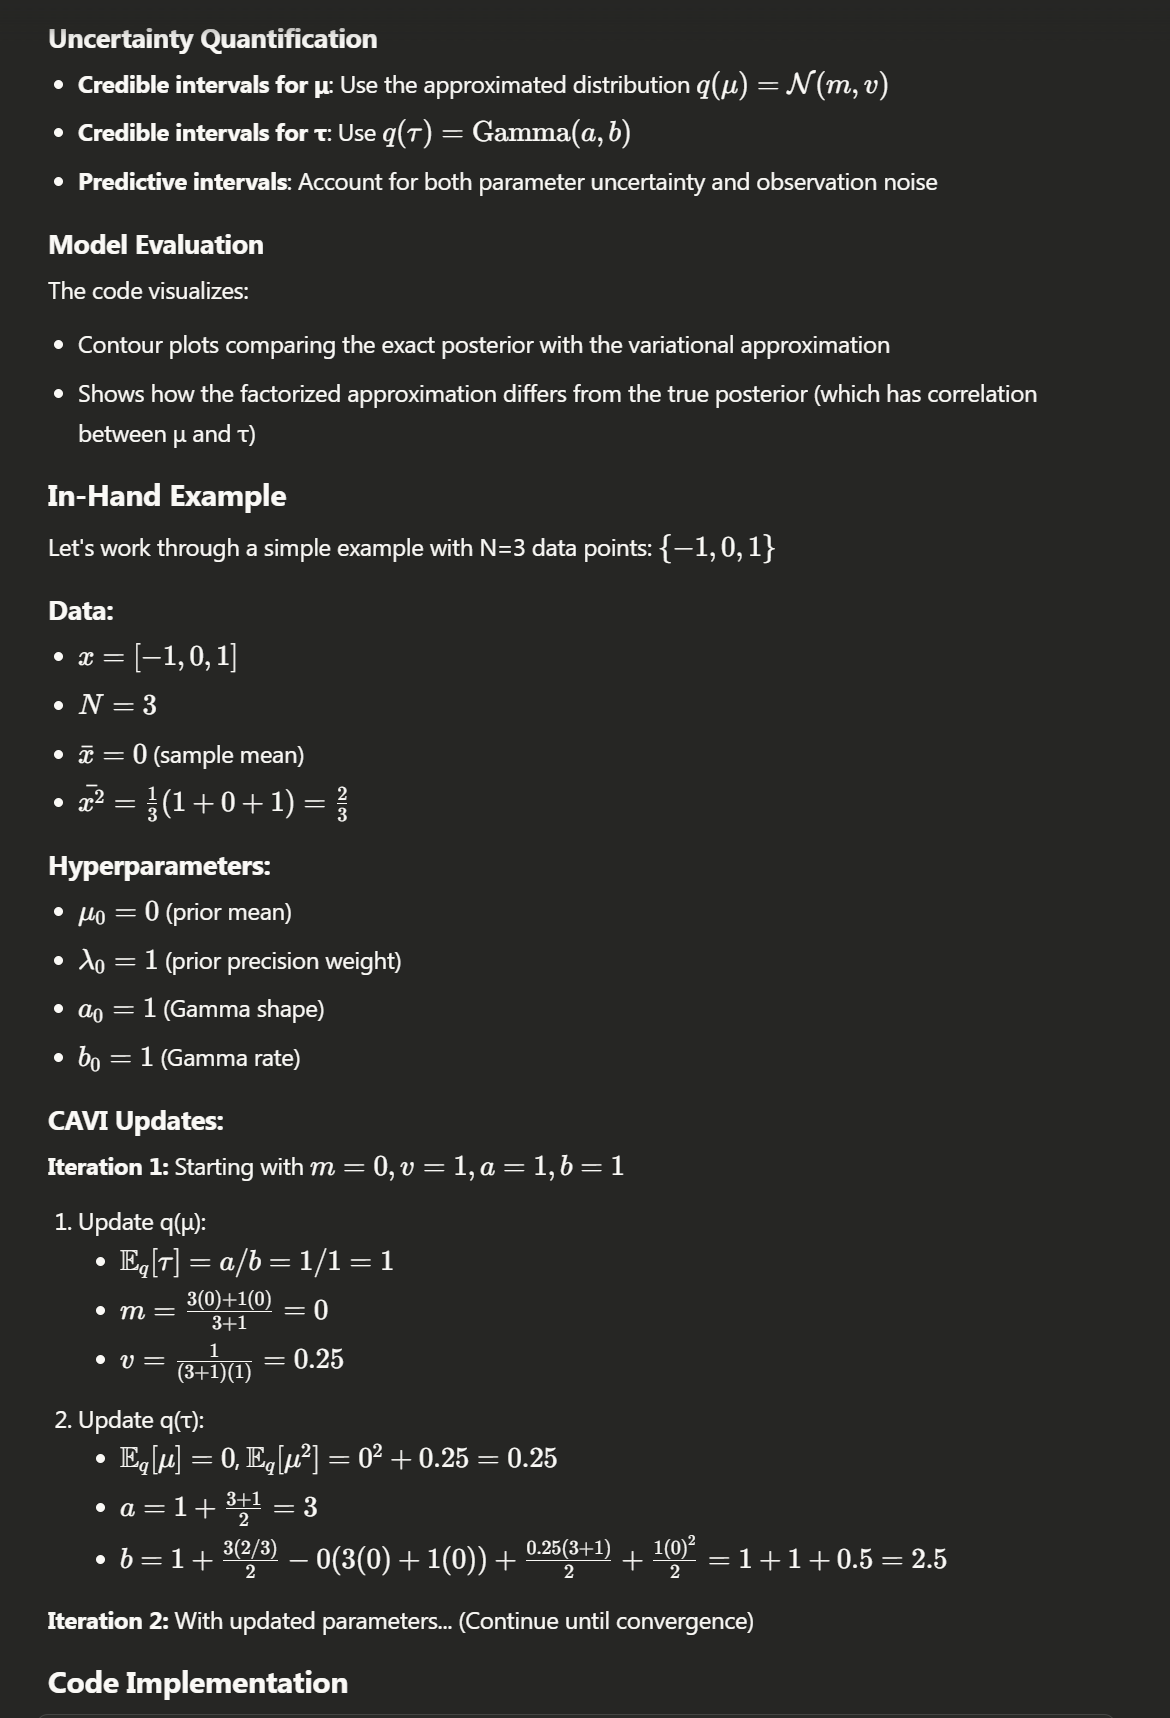


In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

class VariationalApproximation(object):
    def __init__(self, x, mu0=0, lambda0=0, a0=1, b0=1):
        """
        Initialize the VariationalApproximation.
        
        Args:
            x: jnp.ndarray of shape (N,), dataset observations
            mu0: float, prior mean for mu
            lambda0: float, prior precision multiplier for mu
            a0, b0: float, shape and rate parameters of Gamma prior on tau
        """
        # Store data & hyperparameters
        self.x = x                  # shape (N,)
        self.N = len(x)            # number of data points
        self.mu0 = mu0             # prior mean
        self.lambda0 = lambda0     # prior precision weight
        self.a0 = a0               # Gamma prior shape
        self.b0 = b0               # Gamma prior rate

    def initialize(self, m, v, a, b):
        """
        Set initial variational parameters.
        
        Args:
            m: float, initial mean of q(mu)
            v: float > 0, initial variance of q(mu)
            a: float > 0, initial shape of q(tau)
            b: float > 0, initial rate of q(tau)
        
        Returns:
            self
        """
        # Variational parameters for q(mu) ~ N(m, v)
        self.m = m    # mean
        self.v = v    # variance
        
        # Variational parameters for q(tau) ~ Gamma(a, b)
        self.a = a    # shape
        self.b = b    # rate
        
        return self

    def fit_approx(self, num_iterations):
        """
        Run coordinate ascent variational inference (CAVI).
        
        Args:
            num_iterations: int, number of CAVI iterations
        
        Returns:
            self with updated variational parameters
        """
        # Precompute summary statistics
        xbar = jnp.mean(self.x)      # sample mean
        x2bar = jnp.mean(self.x**2)  # mean of squared values
        
        # Initialize parameters
        m, v = self.m, self.v
        a, b = self.a, self.b
        
        for itt in range(num_iterations):
            # Update q(mu)
            tau_mean = a / b  # E_q[tau]
            m = (self.N * xbar + self.lambda0 * self.mu0) / (self.N + self.lambda0)
            v = 1 / (tau_mean * (self.N + self.lambda0))
            
            # Update q(tau)
            mu_mean = m              # E_q[mu]
            mu2_mean = m**2 + v      # E_q[mu^2]
            
            a = self.a0 + (self.N + 1) / 2
            b = (self.b0 + 
                 0.5 * self.N * x2bar - 
                 mu_mean * (self.N * xbar + self.lambda0 * self.mu0) + 
                 0.5 * mu2_mean * (self.N + self.lambda0) + 
                 0.5 * self.lambda0 * self.mu0**2)
        
        # Store optimal parameters
        self.a, self.b = a, b
        self.m, self.v = m, v
        
        return self

    def pdf(self, mu, tau):
        """
        Compute log PDF of the variational approximation.
        
        Args:
            mu: jnp.ndarray, points at which to evaluate q(mu)
            tau: jnp.ndarray, points at which to evaluate q(tau)
        
        Returns:
            log-prob: jnp.ndarray, sum of log q(mu) + log q(tau)
        """
        return log_npdf(mu, self.m, self.v) + log_gamma(tau, self.a, self.b)

# Example usage
x = jnp.array([-1, 0, 1])
approx = VariationalApproximation(x, mu0=0, lambda0=1, a0=1, b0=1)
approx.initialize(m=0, v=1, a=1, b=1)
approx.fit_approx(num_iterations=100)

print(f"Final parameters:")
print(f"q(mu) = N({approx.m:.3f}, {approx.v:.3f})")
print(f"q(tau) = Gamma({approx.a:.3f}, {approx.b:.3f})")

Final parameters:
q(mu) = N(0.000, 0.200)
q(tau) = Gamma(3.000, 2.400)
